## Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

## Data preparation

In [56]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie preparation

In [77]:
def movie_data_processing():

    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))

    

    return movies
movies = movie_data_processing()

In [78]:
def process_dict_columns(movies):
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])

    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))



    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)


    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))


    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)


    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)



    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))

        
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))

    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [79]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    #little error in the date
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))
    return movies

movies = modify_movie_release_date(movies)

### Nan in revenue column

In [80]:
tmdb = pd.read_csv('data/tmdb-movies.csv', sep=',', header=0)

joined = movies.join(tmdb.set_index(['original_title','release_year']), on=['Movie name', 'Movie Year Release'], how='inner', lsuffix='_left', rsuffix='_right')

In [117]:
nbr = ((1-(joined['Movie box office revenue']>0.1)) & (joined['revenue']>0)).sum()
print(f"Number of movies with revenue in tmdb but not in our dataset: {nbr}")

Number of movies with revenue in tmdb but not in our dataset: 524


In [126]:
tmdb[tmdb['original_title']=="Getting Away with Murder: The JonBenét Ramsey Mystery"]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj


In [113]:
diff =((joined[(joined['Movie box office revenue']>0) & (joined['revenue']>0)]['Movie box office revenue']-joined[(joined['Movie box office revenue']>0) & (joined['revenue']>0)]['revenue'])>10000000)

joined[(joined['Movie box office revenue']>0) & (joined['revenue']>0) & diff]

C:\Users\33651\AppData\Local\Temp\ipykernel_24820\3344883331.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  joined[(joined['Movie box office revenue']>0) & (joined['revenue']>0) & diff]


,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,id,...,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,budget_adj,revenue_adj
142,1765938,Convoy,1978-01-01,45000000.0,111.0,{English Language},{United States of America},"{Action/Adventure, Comedy, Action, Drama}",1978,9584,...,male nudity|female nudity|police brutality|wai...,"Truckers form a mile long ""convoy"" in support ...",110,Action|Comedy|Drama,EMI Films Ltd.,6/27/78,31,6.2,4.011241e+07,7.609685e+07
202,336846,Grease,1978-06-16,394589888.0,225.0,{English Language},{United States of America},"{Musical, Romance Film, LGBT, Comedy, Teen, Ro...",1978,621,...,flying car|street gang|running|graduation|musical,Australian good girl Sandy and greaser Danny f...,110,Music,Paramount Pictures|Robert Stigwood Organizatio...,7/7/78,786,7.0,2.005620e+07,6.077490e+08
310,2546429,Friday the 13th: The Final Chapter,1984-04-13,32980880.0,91.0,{English Language},{United States of America},"{Teen, Horror, Cult, Slasher}",1984,9730,...,lake|resurrection|morgue|serial killer|jason v...,"After the Crystal Lake Massacres, Jason is pro...",91,Horror|Thriller,Paramount Pictures,4/13/84,100,5.7,0.000000e+00,6.716935e+01
562,1964091,Next,2007-04-25,76066841.0,95.0,"{German Language, French Language, English Lan...",{United States of America},"{Science Fiction, Thriller, Action}",2007,1738,...,fortune teller|duringcreditsstinger,Las Vegas showroom magician Cris Johnson has a...,96,Action|Science Fiction|Thriller,Paramount Pictures|Virtual Studios|Revolution ...,4/24/07,499,5.9,7.361680e+07,1.915195e+07
595,22358819,Clash of the Titans,2010-03-26,493214993.0,96.0,{English Language},"{United Kingdom, United States of America}","{Adventure, Remake, Action/Adventure, Drama, F...",2010,18823,...,hades|mythology|greek mythology|zeus|medusa,"Born of a god but raised as a man, Perseus is ...",106,Adventure|Fantasy|Action,The Zanuck Company|Legendary Pictures|Thunder ...,4/1/10,1530,5.6,1.250000e+08,2.327131e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80894,21411112,Eden Log,2007-12-26,NaN,98.0,{French Language},{France},"{Thriller, Science Fiction, World cinema, Horr...",2007,14235,...,amnesia|cave|plants|independent film,A man wakes up deep inside a cave. Suffering a...,98,Action|Adventure|Drama|Horror|Science Fiction,ImpÃ©ria|Bac Films,12/26/07,36,4.7,0.000000e+00,0.000000e+00
80957,3746749,Cow Belles,2006-03-24,NaN,93.0,{English Language},{United States of America},"{Children's, Television movie, Comedy, Family ...",2006,24801,...,sports car|sister sister relationship|spoiled ...,"In order to learn how to be responsible, two w...",90,TV Movie|Comedy|Family|Romance,Just Singer Entertainment|Spotted Cow Productions,3/24/06,36,5.1,0.000000e+00,0.000000e+00
81440,22971483,Dug's Special Mission,2009-11-10,NaN,NaN,{English Language},{United States of America},"{Animation, Computer Animation}",2009,24589,...,pixar animated short|dog,"Dug's Special Mission will give ""a little bit ...",5,Animation|Adventure|Comedy|Family|Fantasy,Pixar Animation Studios,11/9/09,48,6.9,0.000000e+00,0.000000e+00
81470,3027347,Blown Away,1994-07-01,30155037.0,120.0,"{Irish, English Language}",{United States of America},"{Action/Adventure, Thriller, Action}",1994,178,...,terrorist|boston|fireworks|orchestra|anarchist,Blown Away tells the story of Jimmy Dove who w...,121,Drama|Action|Thriller,Trilogy Entertainment Group|Metro-Goldwyn-Maye...,7/1/94,53,5.6,0.000000e+00,4.436284e+07


In [63]:
#drop when movie box office revenue is NaN
movies=movies.dropna(subset=['Movie box office revenue'])


### Characters

In [64]:
def characters_data_process():
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    ## This one might be usefull
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)


    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    #little error in the date
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)

    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    return characters
characters = characters_data_process()

### Plot Summaries

In [65]:
from matplotlib.pyplot import plot


def plot_summaries_data_process():
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### First definition of success

In [66]:

mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

movies["Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

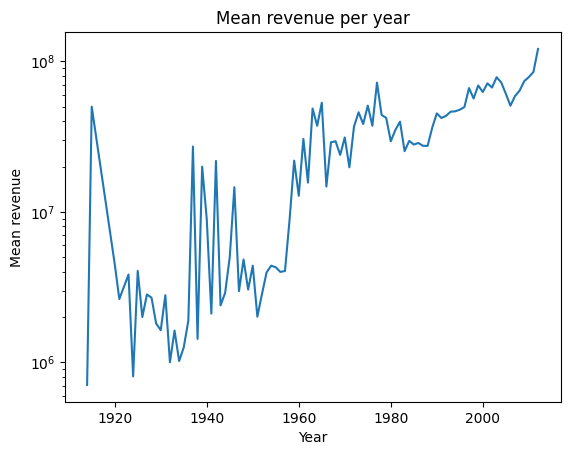

In [67]:

plt.semilogy(mean_revenue_year)
plt.title("Mean revenue per year")
plt.xlabel("Year")
plt.ylabel("Mean revenue")
plt.show()


### Add rotten tomatoes critic score

In [68]:
def processing_rotten_tomatoes_score():
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)

    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating','original_release_date'], inplace=True)

    rotten_movies['Movie Year Release'] = rotten_movies['original_release_date'].map(lambda x: int(x.split('-')[0]))

    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()
# joined_movies = movies.join(rotten_movies.set_index('movie_title'), on='Movie name', how='inner')

# join on movie name and release year
joined_2_movies = movies.join(rotten_movies.set_index(['movie_title', 'Movie Year Release']), on=['Movie name', 'Movie Year Release'], how='inner')


# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

#OK but still some film have different release data on the two dataset=> Wilde 

movie = joined_2_movies

### Add IMDB actor and rating data

In [69]:
#to do

## Analysis

In [70]:
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,{English Language},{United States of America},"{Adventure, Thriller, Supernatural, Science Fi...",2001,0.196169,False
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,{English Language},{United States of America},"{Musical, Comedy, Black-and-white}",1938,2.516221,True
13,171005,Henry V,1989-11-08,10161099.0,137.0,{English Language},{United Kingdom},"{War film, Period piece, Costume drama, Epic, ...",1989,0.280666,False
17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,{English Language},{United States of America},"{Children's Fantasy, Musical, Comedy, Family F...",1964,2.742002,True
21,612710,New Rose Hotel,1999-10-01,21521.0,92.0,{English Language},{United States of America},"{Thriller, Erotic thriller, Future noir, Scien...",1999,0.000311,False


In [71]:
characters.head()

,Wikipedia movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0


In [17]:
movies[movies["Movie box office revenue"]>1e7].sort_values(by=["audience_rating", "tomatometer_rating"], ascending=False).head(20)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
36402,2466773,The Godfather,1972-03-15,268500000.0,177.0,"{English Language, Latin Language, Italian Lan...",{United States of America},"{Drama, Crime Fiction, Film adaptation, New Ho...",1972,7.292592,True,One of Hollywood's greatest critical and comme...,Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo",1972-03-24,Paramount Pictures,98.0,98.0
26366,30625,The Shawshank Redemption,1994-09-10,28341469.0,142.0,{English Language},{United States of America},"{Drama, Crime Fiction, Escape Film, Prison, Bu...",1994,0.608585,False,"The Shawshank Redemption is an uplifting, deep...",Frank Darabont,Frank Darabont,1994-09-10,Columbia Pictures,91.0,98.0
25386,65834,Schindler's List,1993-11-30,321306305.0,186.0,"{French Language, English Language, German Lan...",{United States of America},"{Biographical film, Biography, Drama, Biopic [...",1993,6.944183,True,Schindler's List blends the abject horror of t...,Steven Spielberg,Steven Zaillian,1993-12-15,Universal Pictures,97.0,97.0
59261,31557,"The Good, the Bad and the Ugly",1966-12-23,25100000.0,177.0,"{English Language, Italian Language}","{West Germany, Spain, Italy}","{Revisionist Western, Action, War film, Action...",1966,1.704413,True,Arguably the greatest of the spaghetti western...,Sergio Leone,"Sergio Leone, Luciano Vincenzoni, Furio Scarpe...",1966-12-23,United Artists,97.0,97.0
78722,2812852,Love Jones,1997-03-14,12782749.0,108.0,{English Language},{United States of America},"{Comedy, Romantic comedy, Drama, Romance Film,...",1997,0.192424,False,NaN,Theodore Witcher,Theodore Witcher,1997-03-14,New Line Home Entertainment,73.0,97.0
9952,1897341,The Pianist,2002-05-24,120072577.0,142.0,"{Russian Language, English Language, German La...","{Poland, Germany, France, United Kingdom}","{Biographical film, Drama, War film, History}",2002,1.792322,True,"Well-acted and dramatically moving, The Pianis...",Roman Polanski,Ronald Harwood,2002-12-27,Focus Features,95.0,96.0
47117,21913863,One Flew Over the Cuckoo's Nest,1975-11-19,108981275.0,129.0,{English Language},{United States of America},"{Tragicomedy, Comedy, Drama, Existentialism, F...",1975,2.145094,True,The onscreen battle between Jack Nicholson and...,Milos Forman,"Bo Goldman, Lawrence Hauben",1975-11-19,United Artists,94.0,96.0
11421,5454803,The Lives of Others,2006-03-15,11286112.0,137.0,{German Language},{Germany},"{Political drama, Drama, Thriller, Political t...",2006,0.222516,False,"Unlike more traditional spy films, The Lives o...",Florian Henckel von Donnersmarck,Florian Henckel von Donnersmarck,2006-03-23,Sony Pictures Classics,93.0,96.0
66299,54173,Pulp Fiction,1994-01-01,213928762.0,168.0,"{French Language, English Language, Spanish La...",{United States of America},"{Drama, Ensemble Film, Crime Fiction, Thriller...",1994,4.593760,True,One of the most influential films of the 1990s...,Quentin Tarantino,"Quentin Tarantino, Roger Avary",1994-09-23,Miramax Films,92.0,96.0
27273,167857,The Usual Suspects,1994-01-01,23272306.0,108.0,"{French Language, English Language, Spanish La...","{United States of America, Germany}","{Ensemble Film, Mystery, Crime Fiction, Neo-no...",1994,0.499734,False,"Expertly shot and edited, The Usual Suspects g...",Bryan Singer,"Christopher McQuarrie, Bryan Singer",1995-08-16,Gramercy Pictures,89.0,96.0


# Economic success

We load economics data to compare the movie box office return through history. Furthermore, we analyse if economics data are related with success for some year 

In [18]:
!pip install yfinance

In [19]:
import yfinance

financial_indicator = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max(), format="%Y"))



[*********************100%%**********************]  1 of 1 completed


In [20]:
pd.to_datetime(movies["Movie Year Release"].min(), format="%Y")
financial_indicator["Close"]/financial_indicator["Close"][0]


Date
1927-12-30     1.000000
1928-01-03     1.005663
1928-01-04     1.003397
1928-01-05     0.993771
1928-01-06     1.000000
                ...    
2011-12-23    71.649489
2011-12-27    71.655157
2011-12-28    70.761043
2011-12-29    71.518688
2011-12-30    71.211777
Name: Close, Length: 21097, dtype: float64

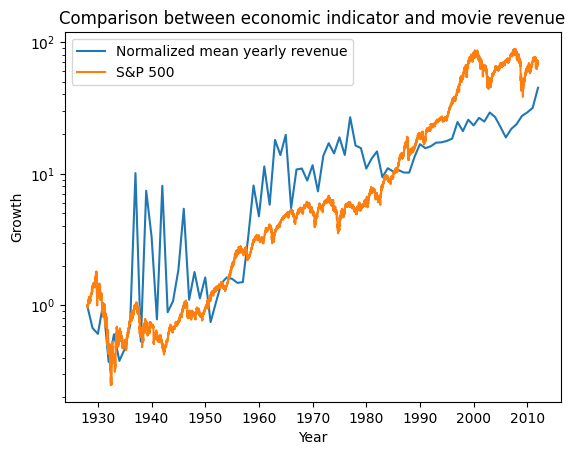

In [21]:
financial_revenue_year = mean_revenue_year[mean_revenue_year.index>financial_indicator.index.year.min()]
financial_revenue_year.index = pd.to_datetime(financial_revenue_year.index, format="%Y") 
plt.semilogy(financial_revenue_year/financial_revenue_year[0], label="Normalized mean yearly revenue")
plt.semilogy(financial_indicator["Close"]/financial_indicator["Close"][0], label="S&P 500")
plt.title("Comparison between economic indicator and movie revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

## Analysis of inflation

In [22]:
!pip install cpi

In [23]:
import cpi

cpi_df = cpi.series.get().to_dataframe()
cpi_df = cpi_df[cpi_df['period_type']=='monthly']
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df = cpi_df.set_index('date').sort_values(by="date")

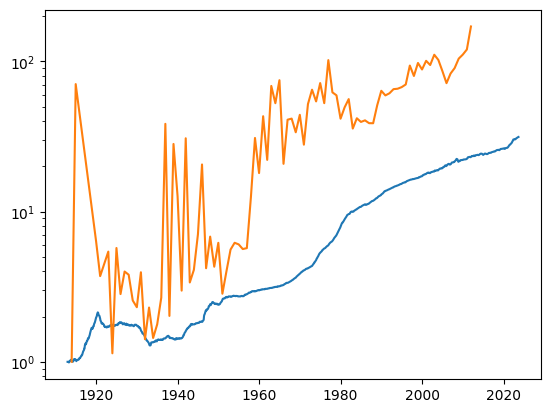

In [24]:
#inflation = cpi_df[(cpi_df.index>financial_revenue_year)]
mean_revenue_year.index = pd.to_datetime(mean_revenue_year.index, format="%Y")
plt.semilogy(cpi_df["value"]/(cpi_df["value"].iloc[0]))
plt.semilogy(mean_revenue_year/mean_revenue_year.iloc[0])


### Adjust the effect of inflation on the movie revenue

In [25]:
mean_revenue_year.iloc[0]

707932.0

In [26]:
movies["Inflated revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]), axis=1)

In [27]:
movies.sort_values(by=["Movie Year Release","Inflated revenue"], ascending=[True, False]).head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating,Inflated revenue
53319,15340505,Neptune's Daughter,1914-04-25,1000000.0,NaN,{English Language},{United States of America},"{Indie, Black-and-white, Silent film}",1914,1.412565,False,NaN,Edward Buzzell,"Dick Chevillat, Dorothy Kingsley, Ray Singer",1949-06-01,MGM Home Entertainment,100.0,59.0,2.926550e+07
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{English Language, Silent film}",{United States of America},"{Drama, Costume drama, Black-and-white, War fi...",1915,1.000000,False,"A deeply flawed cinematic landmark, The Birth ...",D.W. Griffith,"Frank Woods, D.W. Griffith, Frank E. Woods, Th...",1915-03-03,Gravitas,93.0,56.0,1.448787e+09
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{English Language, Silent film}",{United States of America},"{Drama, Costume drama, Black-and-white, War fi...",1915,1.000000,False,The Birth of a Nation overpowers its narrative...,Nate Parker,"Nate Parker, Jean McGianni Celestin",2016-10-07,Fox Searchlight Pictures,72.0,71.0,1.448787e+09
24953,4499436,Way Down East,1920-01-01,4500000.0,147.0,"{English Language, Silent film}",{United States of America},"{Drama, Black-and-white, Romance Film, Action/...",1920,1.000000,False,NaN,D.W. Griffith,"D.W. Griffith, Anthony Paul Kelly",1920-09-03,Kino Lorber,95.0,69.0,6.584737e+07
40247,1346905,The Kid,1921-01-01,2500000.0,60.0,"{English Language, Silent film}",{United States of America},"{Comedy, Drama, Black-and-white, Indie, Silent...",1921,0.949367,False,Charles Chaplin' irascible Tramp is given able...,Charles Chaplin,Charles Chaplin,1921-01-21,First National Pictures Inc.,100.0,95.0,4.087360e+07


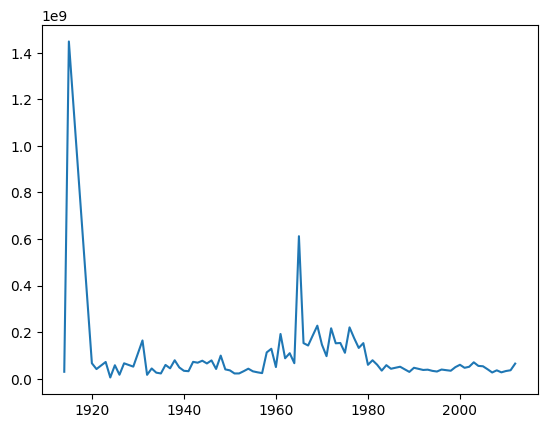

In [28]:
mean_infl_revenue_year = movies.groupby('Movie Year Release')['Inflated revenue'].median()
plt.plot(mean_infl_revenue_year)

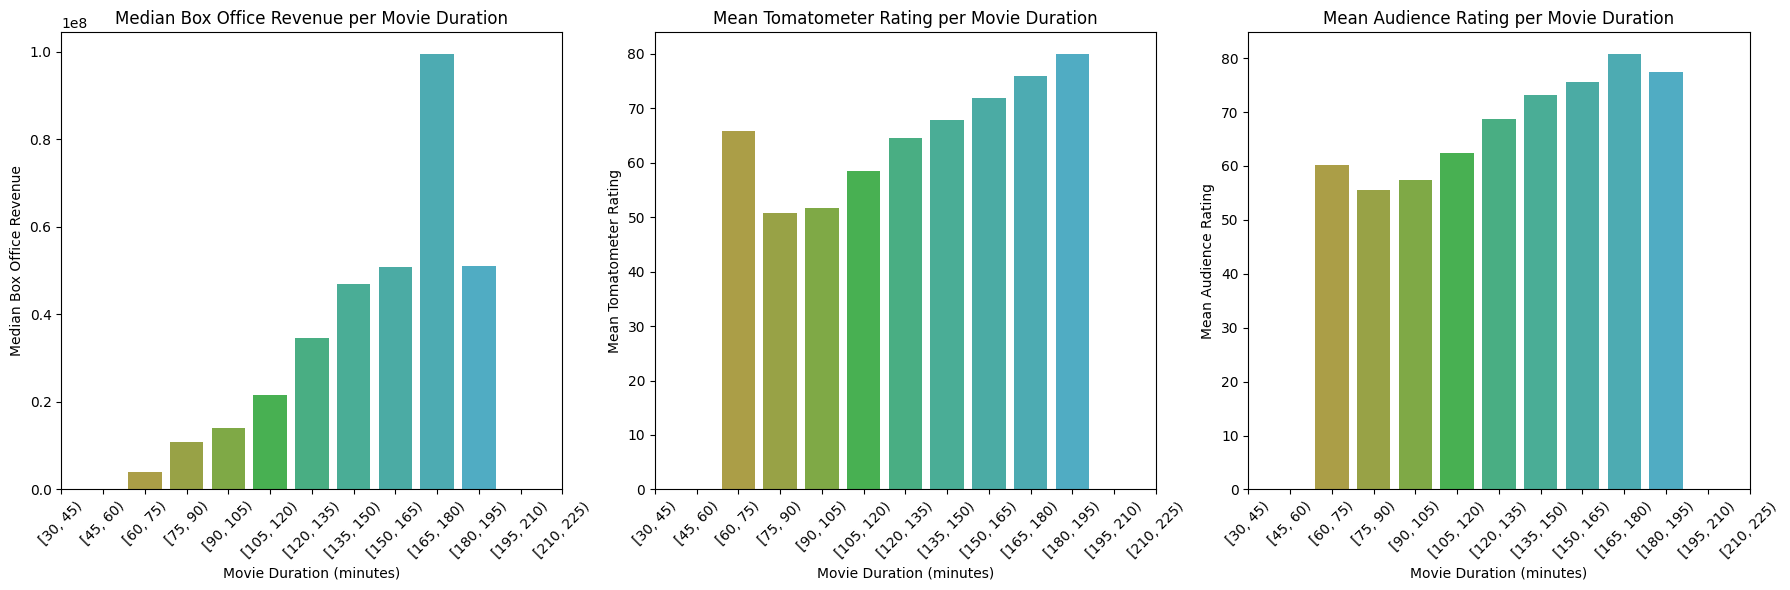

In [34]:
from helpers import convert_and_extract_date, create_length_bins, plot_movie_duration_metrics, explore_month_release_relationship
# Convert the movie release dates to datetime format and extract month and year from the datetime values
movies = convert_and_extract_date(movies)
# Create bins for movie length with a step of 15 minutes up to 300 minutes
filtered_movies, grouped_data = create_length_bins(movies)
# Compare the plots per movie duration for: median box office revenue, mean tomatometer_rating and mean audience_rating
plot_movie_duration_metrics(grouped_data)

### Movie Duration Graph Analysis & Comparison

A common trend in all 3 graphs is the strict increase of 'success' from the 75-90' movie bucket to the 165-180' movie bucket. We only considered buckets with a large enough sample size to provide more useful insight, a minimum threshold of 25 movie occurrences. Extreme values of box office revenues could heavily influence the mean, so we took the median as we have a big enough sample size and more importantly unskewed data.

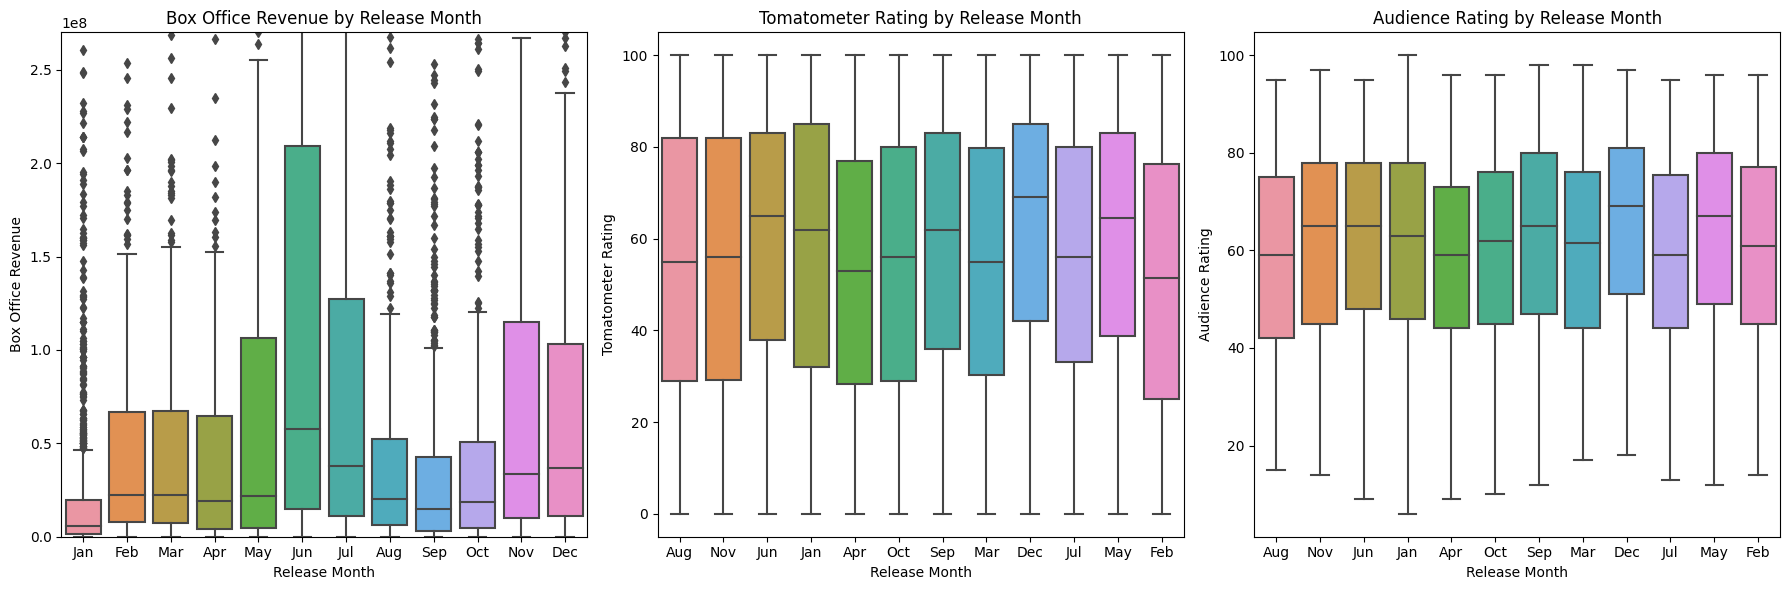

In [35]:
# View the boxplots in monthly order with literal month abbreviations
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Compare the plots per release month for: box office revenue, tomatometer_rating and audience_rating
explore_month_release_relationship(movies, month_order)

### Release Month Graph Analysis & Comparison

It makes sense that there is no significant relation between movie ratings and release month. The interesting plot here is the box office revenue per release month. June, July, November and December are clearly the most profitable movie release months, most likely due to the holiday seasons that can attract more viewers to cinemas. We also notice that the months that follow the holiday season are extremely unprofitable for movie releases, notably January and September: students go back to school after the summer/christmas holidays and general consumers may want to spend less money after their holiday expenses. 